In [12]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
from scipy.optimize import minimize

from signature.tensor_algebra import TensorAlgebra
from signature.tensor_sequence import TensorSequence
from signature.stationary_signature import stationary_signature_from_path
from signature.expected_signature import expected_signature, expected_stationary_signature

from simulation.diffusion import Diffusion

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%%time
ta = TensorAlgebra(dim=2)
ta3 = TensorAlgebra(dim=3)

Compiling...
Compilation finished.
Compiling...
Compilation finished.
CPU times: total: 0 ns
Wall time: 4.2 ms


In [18]:
N = 7
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e221 = ta.from_dict({"221": 1}, trunc=N)

## OU case: $d\sigma_t = \kappa (\theta - \sigma_t) dt + \nu dW_t$

Text(0.5, 1.0, 'Driving Brownian motion W')

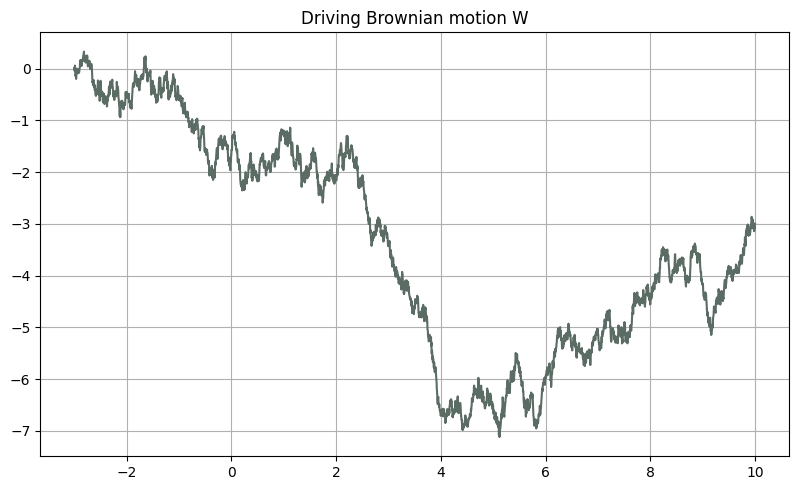

In [19]:
points_per_day = 1 # 4 sec sampling frequency
T = 10

t_grid = np.linspace(-3, T, points_per_day * T * 365 + 1)
rng = np.random.default_rng(seed=42)
size = 10

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W_arr = diffusion.brownian_motion()
W = W_arr[0, 0, :]

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")

In [20]:
t_daily = t_grid[::points_per_day]
W_daily = W[::points_per_day]

path = np.vstack([t_daily, W_daily]).T
path_pos = np.vstack([t_daily[t_daily >= 0], W_daily[t_daily >= 0]]).T
N = 10
W_sig = ta.path_to_sequence(path=path_pos, trunc=N)

In [21]:
N = 10
lam = 5
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

In [204]:
kappa = 9
theta = 0.2
nu = 0.15

ou_arr = diffusion.ornstein_uhlenbeck(lam=kappa, theta=theta, sigma=nu)
ou = ou_arr[0, 0, :]

vol_inst = np.sin(ou) / (1 - 0.5 * ou) * ou**2 * 15
X = np.concatenate([[0], np.cumsum(-0.5 * vol_inst[:-1]**2 * np.diff(t_grid) + vol_inst[:-1] * np.diff(W))])
S = np.exp(X)

Text(0.5, 1.0, 'Instantaneous volatility')

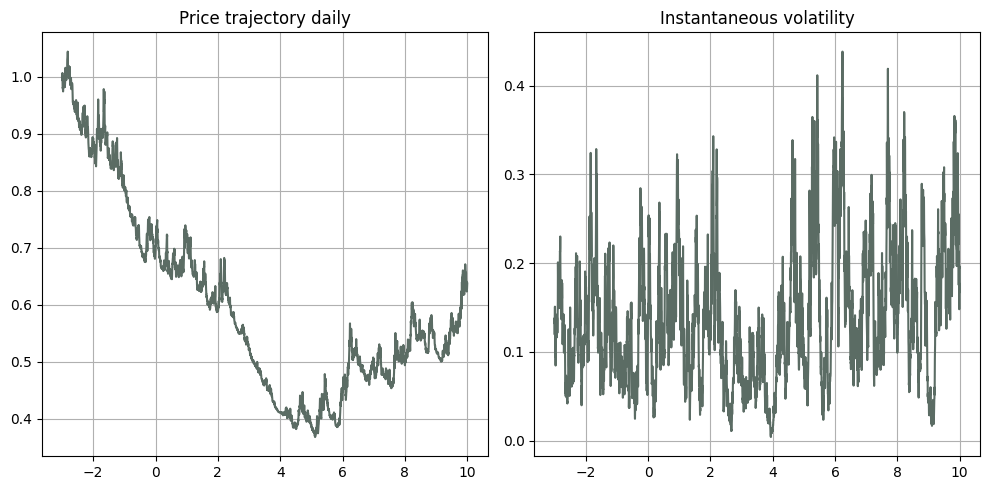

In [205]:
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
vol_daily = vol_inst[::points_per_day]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t_daily, S_daily)
ax[0].set_title("Price trajectory daily")

ax[1].plot(t_daily, vol_inst[::points_per_day])
ax[1].set_title("Instantaneous volatility")

### Regression of vol

In [207]:
t_daily_pos = t_daily[t_daily >= 0]
W_daily_pos = W_daily[t_daily >= 0]
S_daily_pos = S_daily[t_daily >= 0]
t_daily_pos.shape, W_daily_pos.shape

((2808,), (2808,))

In [208]:
trunc = 5
n_params = 2**(trunc + 1) - 1

t_daily_pos = t_daily[t_daily >= 0]
vol_daily_pos = vol_daily[t_daily >= 0]

in_sample_T = 3

in_sample_idx = (t_daily_pos <= in_sample_T)

Y = np.sin(vol_daily_pos)

def get_price_from_l(l):
    vol_coef = ta.from_array(array=l, trunc=trunc)
    vol_proc = (vol_coef @ SigS).squeeze().real
    log_S_sig = np.concatenate([[0], np.cumsum(vol_proc[:-1] * np.diff(W_daily_pos) - np.diff(t_daily_pos) * vol_proc[:-1]**2 / 2)])
    return np.exp(log_S_sig)

def loss_vol_sig(l):
    S_sig = get_price_from_l(l)
    return np.mean((S_daily_pos / S_daily_pos[0] - S_sig)[in_sample_idx]**2)

Text(0.5, 1.0, 'price')

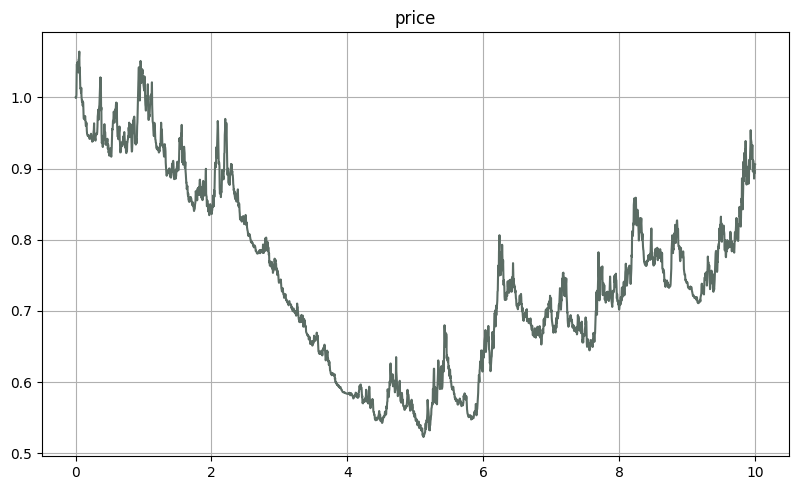

In [209]:
plt.plot(t_daily_pos, S_daily_pos / S_daily_pos[0])
plt.title("price")

In [210]:
%%time
l0 = np.zeros(n_params)
res = minimize(fun=loss_vol_sig, x0=l0)

CPU times: total: 2.94 s
Wall time: 3.48 s


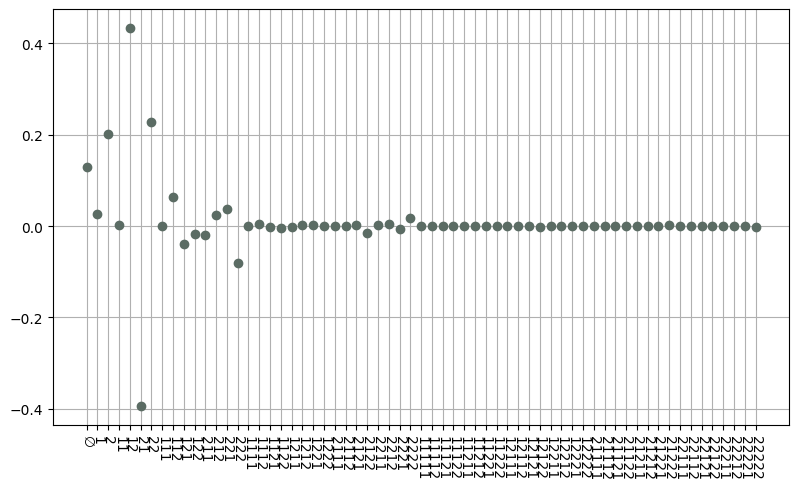

In [211]:
l_reg = ta.from_array(array=res.x, trunc=trunc*2 + 1)
ta.plot_coefficients(l_reg, trunc=5)

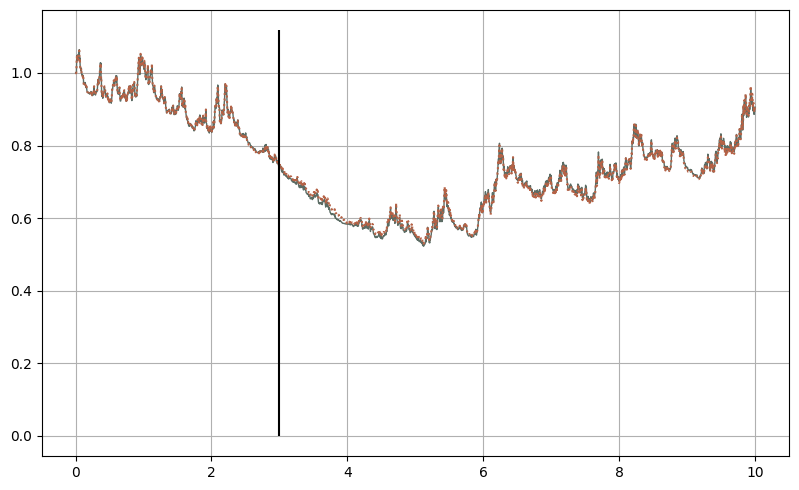

In [212]:
S_reg = get_price_from_l(res.x)

fig, ax = plt.subplots()
ax.plot(t_daily_pos, S_daily_pos / S_daily_pos[0], lw=1)
ax.plot(t_daily_pos, S_reg, ":")
ax.vlines(x=in_sample_T, ymin=0, ymax=1.05 * np.max(S_daily_pos / S_daily_pos[0]), color="k")
# ax.set_ylim([-1, 1])

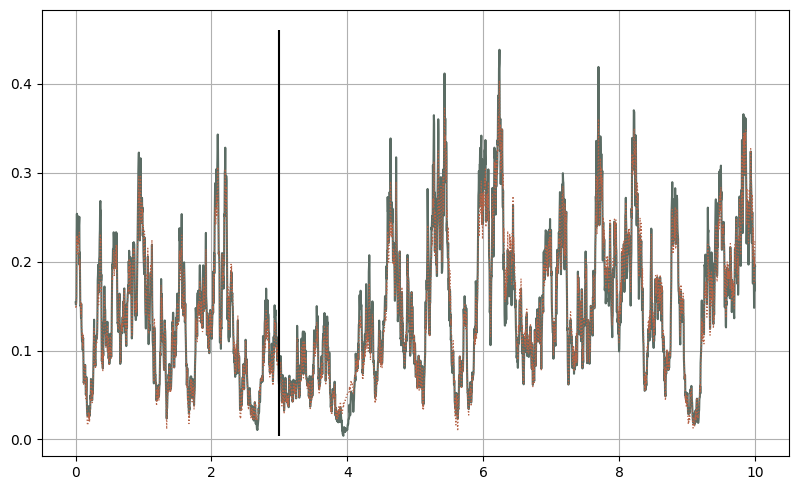

In [213]:
fig, ax = plt.subplots()

vol_daily_pos = vol_inst[t_grid >= 0][::points_per_day]
ax.plot(t_daily_pos, vol_daily_pos)
ax.plot(t_daily_pos, (l_reg @ SigS).real, ":", lw=0.9)
ax.vlines(x=in_sample_T, ymin=0.95 * np.min(vol_daily_pos), ymax=1.05 * np.max(vol_daily_pos), color="k")
# ax.set_ylim([-1, 1])

## Real data

In [22]:
!pip install openpyxl

In [23]:
import pandas as pd

spx_data = pd.read_csv("data/spx_data.csv", index_col=0)
vix_data = pd.read_csv("data/vix_data.csv", index_col=0)
rv_data = pd.read_excel("data/rv_data.xlsx", index_col=0)

In [24]:
spx_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0
...,...,...,...,...,...,...,...
2020-01-17,3323.659912,3329.879883,3318.860107,3329.620117,3726220000,0.0,0.0
2020-01-21,3321.030029,3329.790039,3316.610107,3320.790039,4104840000,0.0,0.0
2020-01-22,3330.020020,3337.770020,3320.040039,3321.750000,3623780000,0.0,0.0
2020-01-23,3315.770020,3326.879883,3301.870117,3325.540039,3766710000,0.0,0.0


In [25]:
rv_spx = rv_data[rv_data.Symbol == ".SPX"]
rv_spx["realized_vol"] = np.sqrt(rv_spx.rv5 * 252.25)

C:\Users\DM6579\AppData\Local\Temp\ipykernel_28272\1879737745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_spx["realized_vol"] = np.sqrt(rv_spx.rv5 * 252.25)


In [26]:
dates_grid = pd.to_datetime(pd.Series(rv_spx.index))

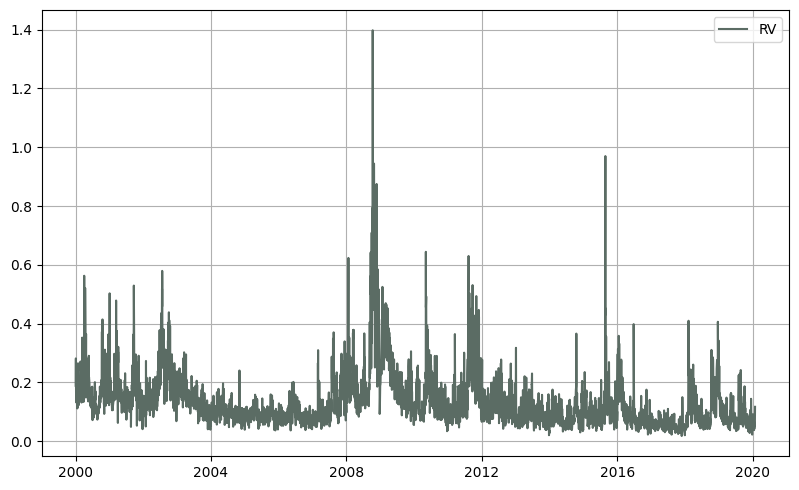

In [27]:
# plt.plot(np.array(rv_spx.close_price))
plt.plot(dates_grid, np.array(rv_spx.realized_vol), label="RV")
# plt.plot(np.array(vix_data.Close) / 100, label="VIX")
plt.legend()

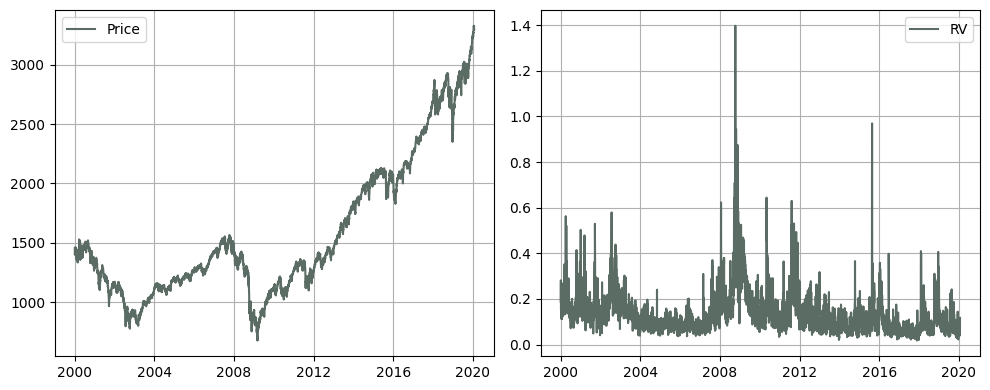

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

rv_mkt = np.array(rv_spx.realized_vol)
price_mkt = np.array(rv_spx.close_price)
time_grid = np.arange(len(price_mkt)) / 252

ax[0].plot(dates_grid, price_mkt, label="Price")
ax[0].legend()
ax[1].plot(dates_grid, rv_mkt, label="RV")
ax[1].legend()

In [29]:
def price_and_vol_to_bm(time_grid, price, vol):
    dB = (np.diff(np.log(price)) + np.diff(time_grid) * vol[:-1]**2 / 2) / vol[:-1]
    B = np.concatenate([[0], np.cumsum(dB)])
    return B

def bm_and_vol_to_price(time_grid, B, vol):
    log_S_sig = np.concatenate([[0], np.cumsum(vol[:-1] * np.diff(B) - np.diff(time_grid) * vol[:-1]**2 / 2)])
    return np.exp(log_S_sig)

Mean = 0.001849804668937487 , Std = 1.3238750049489807


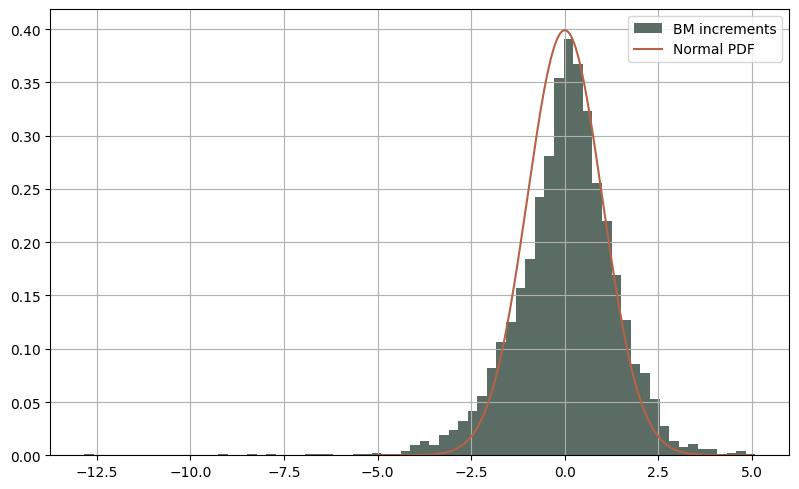

In [30]:
from scipy.stats import norm
x_grid = np.linspace(-5, 5, 500)

# dB = np.diff(price_mkt) / price_mkt[:-1] / rv_mkt[:-1]
# B = np.concatenate([[0], np.cumsum(dB)])
B = price_and_vol_to_bm(time_grid, price_mkt, rv_mkt)
dB = np.diff(B)
dt = np.diff(time_grid)
plt.hist(dB / np.sqrt(dt), bins=70, density=True, label="BM increments")
plt.plot(x_grid, norm.pdf(x_grid), label="Normal PDF")
plt.legend()
print("Mean =", dB.mean(), ", Std =", (dB / np.sqrt(dt)).std())

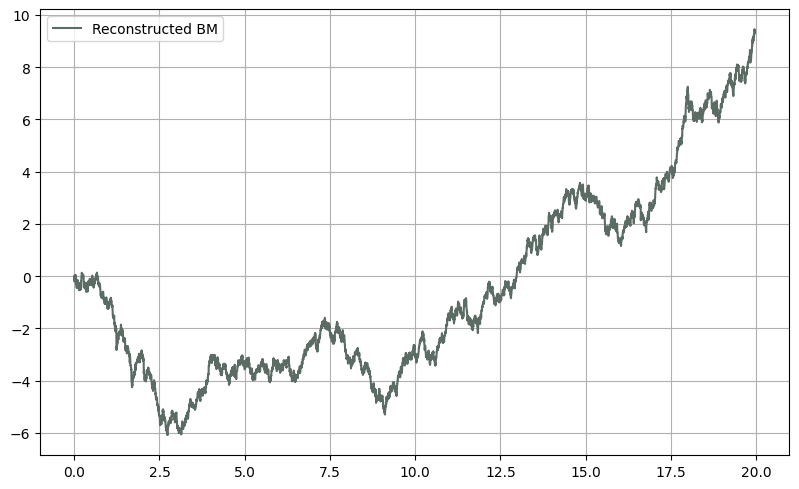

In [31]:
plt.plot(time_grid, B, label="Reconstructed BM")
plt.legend()

## Signature of the same BM

In [32]:
path = np.vstack([time_grid, B]).T
N = 7
lam1 = 3
lam2 = 10

burn_in = 3
StatSig1 = stationary_signature_from_path(path=path, trunc=N, t_grid=time_grid - burn_in, lam=lam1)
StatSig2 = stationary_signature_from_path(path=path, trunc=N, t_grid=time_grid - burn_in, lam=lam2)

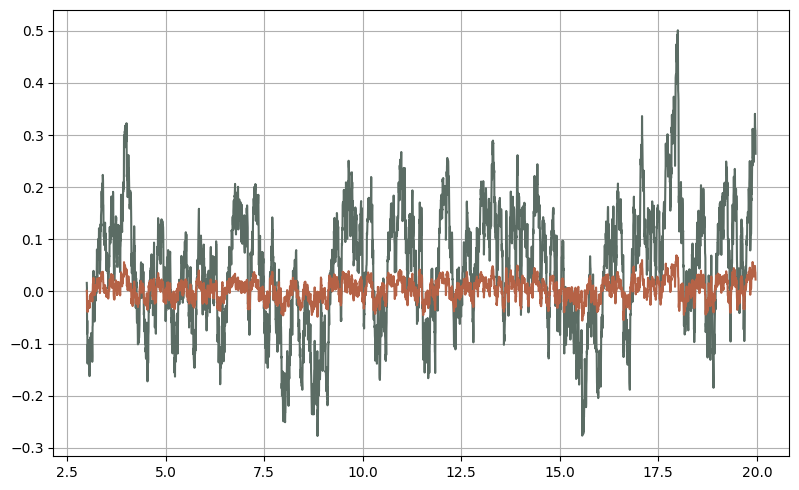

In [978]:
plt.plot(time_grid[time_grid >= burn_in], (e12 @ StatSig1).squeeze().real)
plt.plot(time_grid[time_grid >= burn_in], (e12 @ StatSig2).squeeze().real)

In [979]:
time_grid_stat = time_grid[time_grid >= burn_in]
price_mkt_stat = price_mkt[time_grid >= burn_in]
rv_mkt_stat = rv_mkt[time_grid >= burn_in]
B_stat = B[time_grid >= burn_in]

### Fitting the price process

In [980]:
trunc = 4
n_params = 2**(trunc + 1) - 1

in_sample_T = 6

in_sample_idx = (time_grid_stat <= in_sample_T)

def get_vol_from_l(l):
    vol_coef_1 = ta.from_array(array=l[:n_params], trunc=trunc)
    vol_coef_2 = ta.from_array(array=l[n_params:], trunc=trunc)
    return (vol_coef_1 @ StatSig1).squeeze().real + (vol_coef_2 @ StatSig2).squeeze().real

def get_price_from_l(l):
    vol_proc = get_vol_from_l(l)
    return bm_and_vol_to_price(time_grid=time_grid_stat, B=B_stat, vol=vol_proc)

def loss_vol_sig(l):
    S_sig = get_price_from_l(l)
    return np.mean((price_mkt_stat / price_mkt_stat[0] - S_sig)[in_sample_idx]**2)
    
def loss_vol_rv(l):
    vol_proc = get_vol_from_l(l)
    return np.mean((vol_proc - rv_mkt_stat)[in_sample_idx]**2)

In [983]:
%%time
l0 = np.zeros(n_params * 2)
res = minimize(fun=lambda x: loss_vol_rv(x) * 1 + loss_vol_sig(x) * 0.2, x0=l0)

CPU times: total: 30.7 s
Wall time: 37.5 s


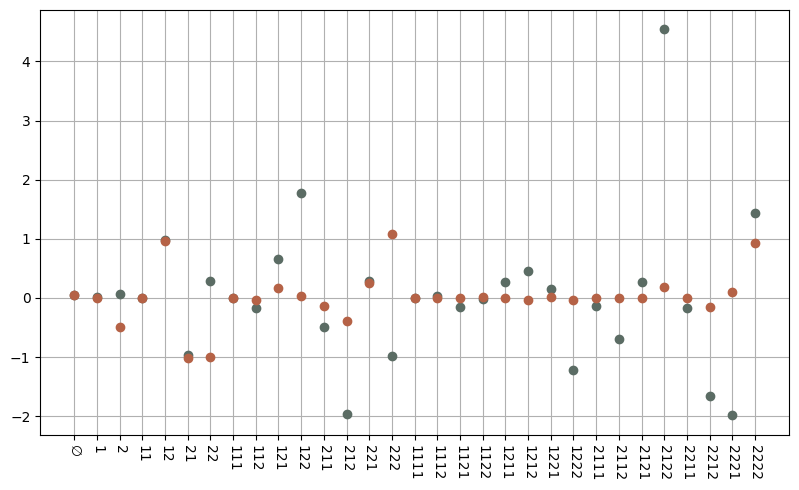

In [984]:
fig, ax = plt.subplots()

l_reg_1 = ta.from_array(array=res.x[:n_params], trunc=trunc)
l_reg_2 = ta.from_array(array=res.x[n_params:], trunc=trunc)

ta.plot_coefficients(l_reg_1, trunc=trunc, ax=ax)
ta.plot_coefficients(l_reg_2, trunc=trunc, ax=ax)

In [985]:
loss_vol_rv(res.x), loss_vol_sig(res.x)

(0.0007728866765589786, 0.0004473380339978407)

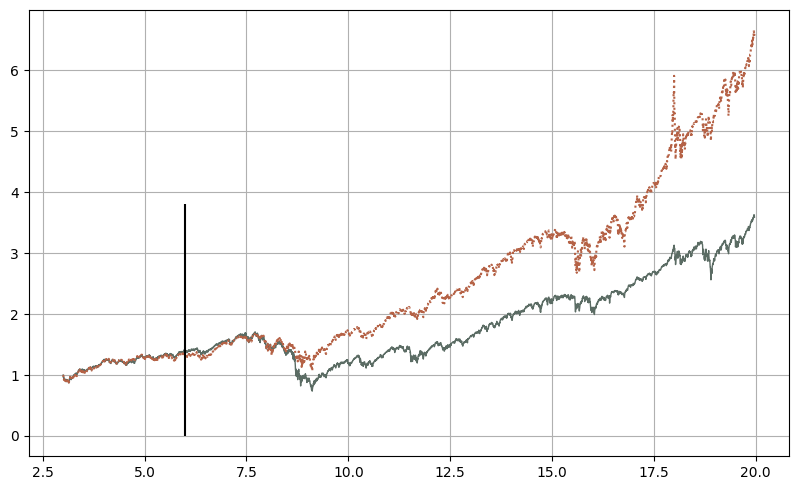

In [986]:
S_reg = get_price_from_l(res.x)

fig, ax = plt.subplots()
ax.plot(time_grid_stat, price_mkt_stat / price_mkt_stat[0], label="Normalized price", lw=1)
ax.plot(time_grid_stat, S_reg, ":")
ax.vlines(x=in_sample_T, ymin=0, ymax=1.05 * np.max(price_mkt_stat / price_mkt_stat[0]), color="k")
# ax.set_ylim([-1, 1])

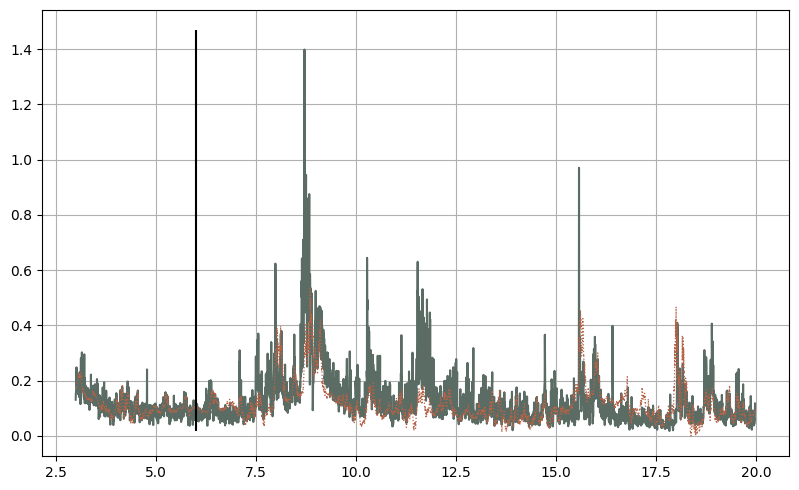

In [987]:
fig, ax = plt.subplots()

vol_daily_pos = vol_inst[t_grid >= 0][::points_per_day]
vol_sig_stat = get_vol_from_l(res.x)

ax.plot(time_grid_stat, rv_mkt_stat)
ax.plot(time_grid_stat, vol_sig_stat, ":", lw=0.9)
ax.vlines(x=in_sample_T, ymin=0.95 * np.min(rv_mkt_stat), ymax=1.05 * np.max(rv_mkt_stat), color="k")
# ax.set_ylim([-1, 1])

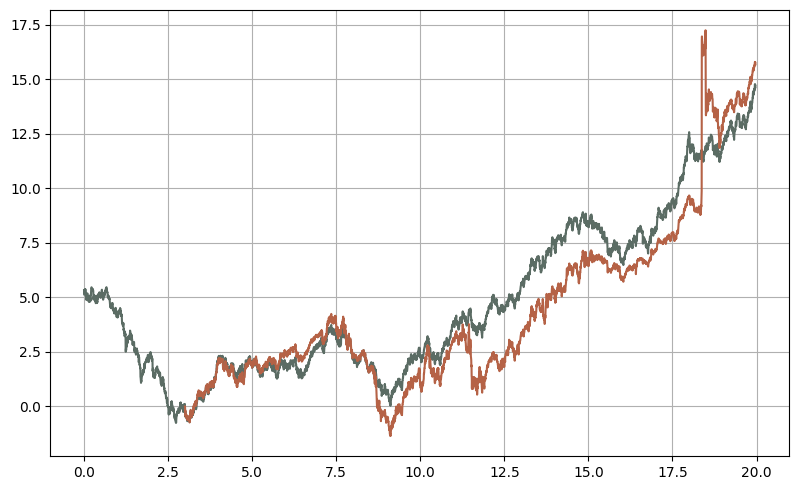

In [988]:
dB_sig = np.diff(price_mkt_stat) / price_mkt_stat[:-1] / vol_sig_stat[:-1]
B_sig = np.concatenate([[0], np.cumsum(dB_sig)])
plt.plot(time_grid, B - B[time_grid >= burn_in][0])
plt.plot(time_grid_stat, B_sig)

## Signature of the stock returns

In [33]:
qv = np.concatenate([[0], np.cumsum(np.diff(np.log(price_mkt))**2)])
path = np.vstack([time_grid, np.log(price_mkt), qv]).T
N = 4
lam1 = 4.5
lam2 = 12

burn_in = 3

# PB: always using market returns in the signature
StatSig1 = stationary_signature_from_path(path=path, trunc=N, t_grid=time_grid - burn_in, lam=lam1)
# StatSig2 = stationary_signature_from_path(path=path, trunc=N, t_grid=time_grid - burn_in, lam=lam2)

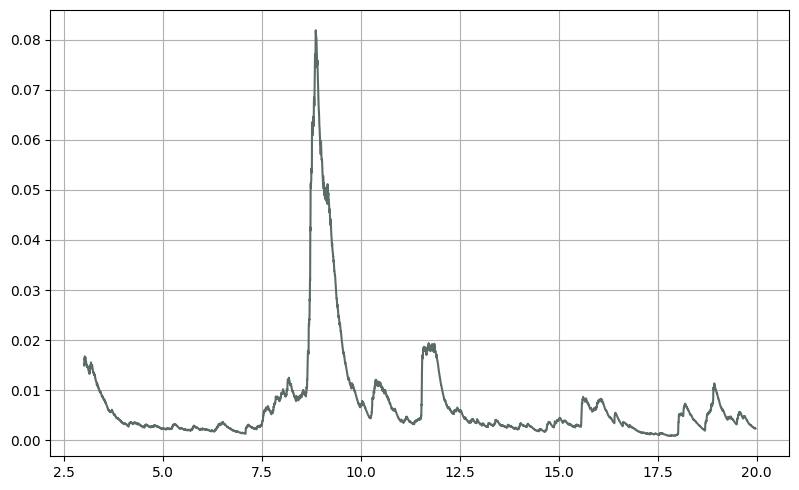

In [36]:
plt.plot(time_grid[time_grid >= burn_in], (ta3.from_dict({"2": 1}, trunc=5) @ StatSig1).squeeze().real)

In [37]:
time_grid_stat = time_grid[time_grid >= burn_in]
price_mkt_stat = price_mkt[time_grid >= burn_in]
rv_mkt_stat = rv_mkt[time_grid >= burn_in]
B_stat = B[time_grid >= burn_in]

In [111]:
trunc = 3
n_params = ta3.alphabet.number_of_elements(trunc)

in_sample_T = 4

in_sample_idx = (time_grid_stat <= in_sample_T)

def get_vol_from_l(l):
    vol_coef_1 = ta3.from_array(array=l[:n_params], trunc=trunc)
    # vol_coef_2 = ta.from_array(array=l[n_params:], trunc=trunc)
    return (vol_coef_1 @ StatSig1).squeeze().real # + (vol_coef_2 @ StatSig2).squeeze().real

def get_price_from_l(l):
    vol_proc = get_vol_from_l(l)
    return bm_and_vol_to_price(time_grid=time_grid_stat, B=B_stat, vol=vol_proc)

def loss_price(l):
    S_sig = get_price_from_l(l)
    return np.mean((price_mkt_stat / price_mkt_stat[0] - S_sig)[in_sample_idx]**2)
    
def loss_vol(l):
    vol_proc = get_vol_from_l(l)
    return np.mean((vol_proc - rv_mkt_stat)[in_sample_idx]**2)

def loss_integrated_vol(l):
    vol_proc = get_vol_from_l(l)
    return np.mean((dt[0] * (np.cumsum(vol_proc) - np.cumsum(rv_mkt_stat)))[in_sample_idx]**2)

In [112]:
%%time
l0 = np.zeros(n_params)

weight_price = 1
weight_vol = 0.2 * 0.5

res = minimize(fun=lambda x: loss_vol(x) * weight_vol + loss_price(x) * weight_price, x0=l0)

CPU times: total: 7.06 s
Wall time: 7.31 s


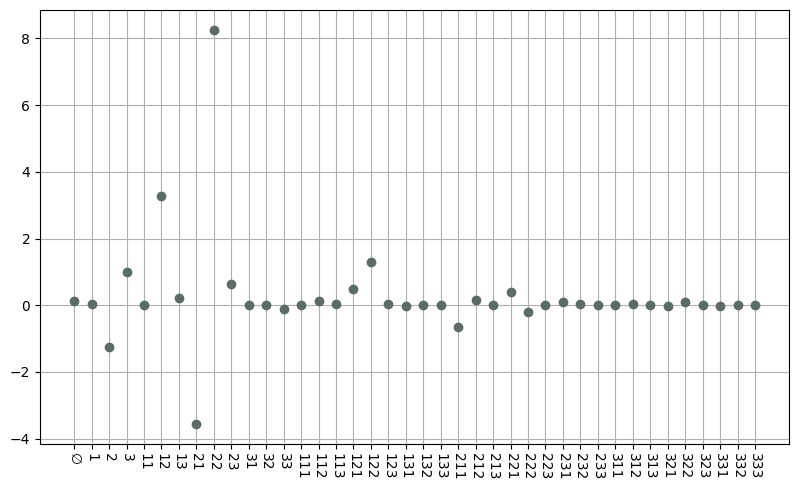

In [113]:
fig, ax = plt.subplots()

l_reg_1 = ta3.from_array(array=res.x[:n_params], trunc=trunc)

ta3.plot_coefficients(l_reg_1, trunc=trunc, ax=ax)

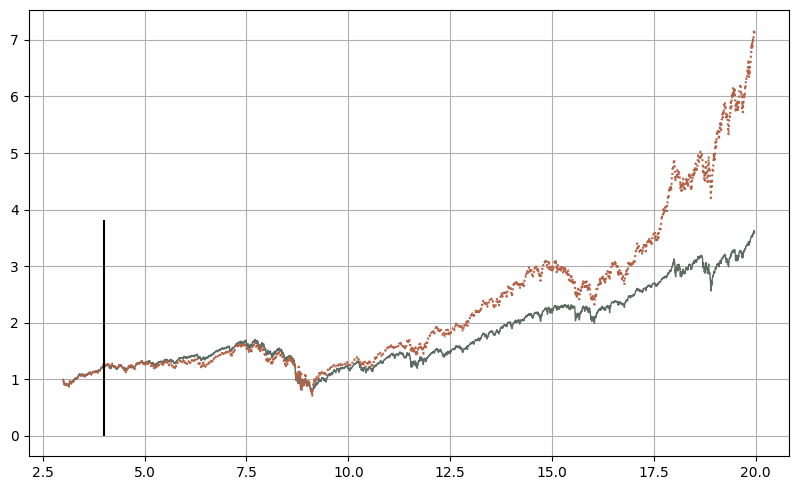

In [114]:
S_reg = get_price_from_l(res.x)

fig, ax = plt.subplots()
ax.plot(time_grid_stat, price_mkt_stat / price_mkt_stat[0], label="Normalized price", lw=1)
ax.plot(time_grid_stat, S_reg, ":")
ax.vlines(x=in_sample_T, ymin=0, ymax=1.05 * np.max(price_mkt_stat / price_mkt_stat[0]), color="k")
# ax.set_ylim([-1, 1])

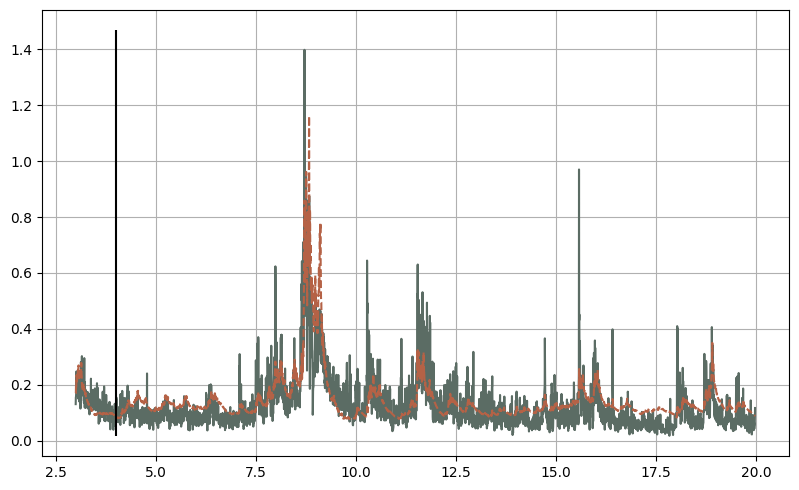

In [117]:
fig, ax = plt.subplots()

vol_sig_stat = get_vol_from_l(res.x)

ax.plot(time_grid_stat, (rv_mkt_stat))
ax.plot(time_grid_stat, (vol_sig_stat), "--")
ax.vlines(x=in_sample_T, ymin=0.95 * np.min(rv_mkt_stat), ymax=1.05 * np.max(rv_mkt_stat), color="k")
# ax.set_ylim([-1, 1])

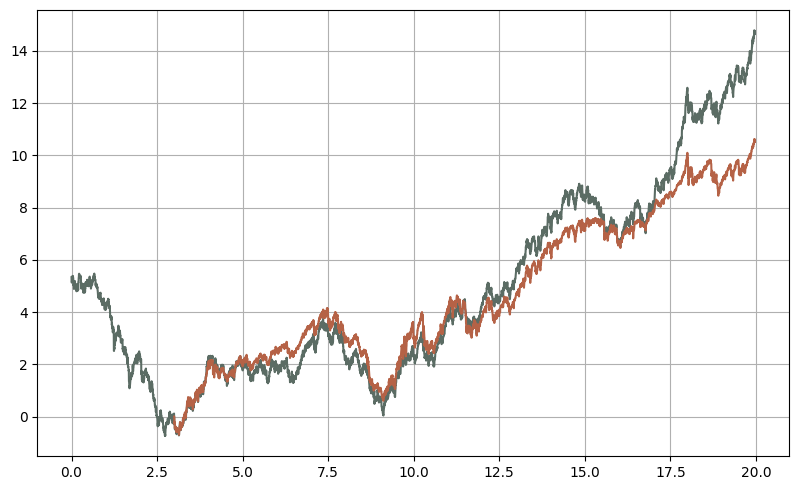

In [118]:
B_sig = price_and_vol_to_bm(time_grid_stat, price_mkt_stat, vol_sig_stat)
plt.plot(time_grid, B - B[time_grid >= burn_in][0])
plt.plot(time_grid_stat, B_sig)

### TODO: implement "fair" simulation of the StatSig PDV